# IMPORTS

In [1]:
from novelty_detection.data import load_data
df = load_data("gaia_data.csv", header_names=None)
print(df.shape)
df.head()

(203206, 13)


,Unnamed: 0,T_ext,Solar_irrad,T_imp,T_ret,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow
0,2022-05-13 12:00:00+00:00,24.40,874.0,9.880005,10.869995,3.05,16.5,15.70,0.25,2923.0,2476.0,0.0,3153.0
1,2022-05-13 12:01:00+00:00,NaN,NaN,NaN,NaN,3.05,16.3,15.70,0.25,2923.0,2476.0,0.0,3153.0
2,2022-05-13 12:02:00+00:00,24.35,875.0,9.940002,10.750000,3.10,16.4,15.75,0.30,2793.0,2476.0,0.0,3211.0
3,2022-05-13 12:03:00+00:00,NaN,NaN,NaN,NaN,3.10,16.5,15.65,0.25,2793.0,2606.0,0.0,3196.0
4,2022-05-13 12:04:00+00:00,24.51,875.0,9.940002,10.899994,3.05,16.4,15.55,0.25,2779.0,2505.0,0.0,3196.0


# PREPROCESSING

In [2]:
from novelty_detection.preprocessing import *

columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Refr1_power', 
           'Refr2_power', 'BC1_flow', 'BC2_flow', 
           'Refr1_flow', 'Refr2_flow', 'T_ret']

max_minutes=30
rows_to_skip=2
max_consecutive_nans=30
thresh_len=1000

dfs = preprocessing_pipeline(df, max_minutes, rows_to_skip, max_consecutive_nans, thresh_len, columns)

In [3]:
choosen_df=1
df_index = dfs[choosen_df]
print(df_index.shape)
df_index.head()

(15862, 12)


,T_ext,Solar_irrad,T_imp,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow,T_ret
datetime,,,,,,,,,,,,
2022-05-18 00:02:00+00:00,19.450001,0.0,15.040009,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.320007
2022-05-18 00:04:00+00:00,19.450001,0.0,15.070007,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.320007
2022-05-18 00:06:00+00:00,19.450001,0.0,14.980011,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.260010
2022-05-18 00:08:00+00:00,19.510000,0.0,15.040009,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.260010
2022-05-18 00:10:00+00:00,19.510000,0.0,15.110001,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.275009


# DECISION PLOTS

In [4]:
from novelty_detection.data import save_img

x_columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Refr1_power', 
           'Refr2_power', 'BC1_flow', 'BC2_flow', 
           'Refr1_flow', 'Refr2_flow']

y_column = ['T_ret']

all_columns = x_columns + y_column

plt1 = timeseries_plot(df_index, all_columns, (3,4), plot_size=(500,800), margin=300, spacing =435, dpi=200.)
plt2 = correlation_plot(df_index, x_columns, max_shift=2000, plot_size=(600,1000), margin=300, spacing =435, dpi=200.)
plt3 = frequency_plot(df_index, all_columns, (3,4), frate=1/120, max_freq=0.00004, plot_size=(500,800), margin=150, spacing =300, dpi=200.)

save_img(plt1, 'timeseries_plot.png', data_type='plots')
save_img(plt2, 'correlation_plot.png', data_type='plots')
save_img(plt3, 'frequency_plot.png', data_type='plots')

# SOM

## Split

In [5]:
from sklearn.model_selection import train_test_split

X=df_index[x_columns].to_numpy()
y=df_index[y_column].to_numpy()

# train and test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print('x train shape: ', train_x.shape)
print('y train shape: ', train_y.shape) 
print('x test shape: ', test_x.shape)
print('x test shape: ', test_y.shape)

x train shape:  (12689, 11)
y train shape:  (12689, 1)
x test shape:  (3173, 11)
x test shape:  (3173, 1)


## Scale

In [6]:
from novelty_detection.preprocessing import minmax_scaler_given_parameters, std_scaler_given_parameters

max_val = train_x.max()
min_val = train_x.min()
mu = train_x.mean(0)
s = train_x.std(0)

#train_x_norm = minmax_scaler_given_parameters(train_x, min_val, max_val)
#test_x_norm = minmax_scaler_given_parameters(test_x, min_val, max_val)

train_x_norm = std_scaler_given_parameters(train_x, mu, s)
test_x_norm = std_scaler_given_parameters(test_x, mu, s)

## Training

In [13]:
from novelty_detection.som import SOM

model=SOM(som_grid_size=(20,20),
          max_distance=4,
          learning_rate_0=0.5,
          max_iter=100000,
          random_state=0,
          sigma_0=1, 
          sigma_decay=0.0005,
          learning_rate_decay=0.0005,
          methods={'init_som': 'sq_normal',
                  'bmu_distance': 'cityblock',
                  'compute_neighborhood': 'half',
                  'update_sigma_and_learning_rate': 'constant'}) 
model=model.fit(train_x_norm, epochs=8)
som=model.som
som_dataset=som.reshape(-1,som.shape[2])

In [15]:
from sklearn.decomposition import PCA

# 2D vizualization
pca = PCA(n_components = 2)
pca_som = pca.fit_transform(som_dataset)

# Amount of explained variance kept 2D
exp_variance_2d = pca.explained_variance_ratio_
print(f"SOM data 2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# 3D vizualization
pca_train = pca.fit_transform(train_x_norm)
exp_variance_2d = pca.explained_variance_ratio_
print(f"Train data 2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

SOM data 2D: Total = 0.8612131431510326 and per components = [0.7262195  0.13499364]
Train data 2D: Total = 0.7395463303849981 and per components = [0.60648735 0.13305898]


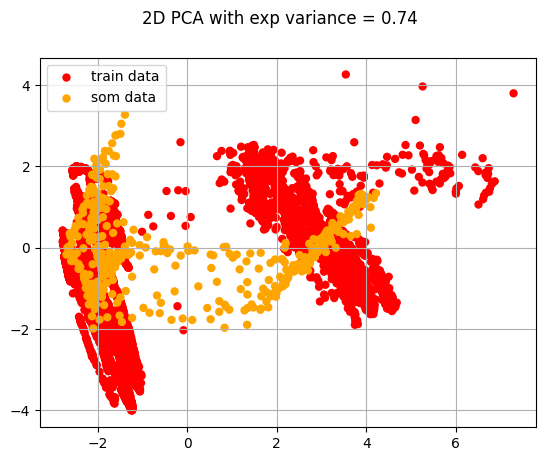

In [16]:
# Plot of the 2D PCA results
fig, ax = plt.subplots()

ax.scatter(pca_train[:,0], pca_train[:,1], color="red", label="train data", edgecolors='none')
ax.scatter(pca_som[:,0], pca_som[:,1], color="orange", label="som data", edgecolors='none')
#ax.scatter(-pca_som[:,0]+0.25, pca_som[:,1], color="blue", label="som data transformed", edgecolors='none')

ax.legend()
ax.grid(True)

fig.suptitle(f"2D PCA with exp variance = {round(np.sum(exp_variance_2d), 3)}")

plt.show()